In [7]:
#Importation des libraries nécessaires pour le projet
import pandas as pd #Pour la manipulation des données
import numpy as np #Pour les calculs mathématiques
import matplotlib.pyplot as plt #Pour les visualisations graphiques
import seaborn as sns #Pour les visualisations statistiques
import plotly #Pour les visualisations interactives
import plotly.express as px #Pour des visualisations interactives demandant moins de code
from ipywidgets import widgets, interactive #Pour les widgets interactifs

In [8]:
# Lecture des fichiers csv nécessaires à notre projet
GDP = pd.read_csv("DATASETS//CSV//national-gdp-wb.csv")
POP = pd.read_csv("DATASETS//CSV//population.csv")
CO2 = pd.read_csv("DATASETS//CSV//co2-emissions-and-gdp.csv")
STOCK = pd.read_csv("DATASETS//CSV//stock.csv")  
MILITARY = pd.read_csv("DATASETS//CSV//military.csv")

# Lecture et conversion des fichiers csv en dataframe
df_gdp = pd.DataFrame(GDP)
df_pop = pd.DataFrame(POP)
df_co2 = pd.DataFrame(CO2)
df_military = pd.DataFrame(MILITARY)
df_stock = pd.DataFrame(STOCK)

# Formattage des données pour les rendre plus lisibles et permettre les fusions de données
df_pop = df_pop.rename(columns={"Population - Sex: all - Age: all - Variant: estimates": "Population"})
df_gdp = df_gdp.rename(columns={"GDP, PPP (constant 2017 international $)": "GDP"})
df_gdp = df_gdp.rename(columns={"Country Name": "Entity"})
df_gdp = df_gdp.rename(columns={"Country Code": "Code"})
df_stock = df_stock.rename(columns={"Market capitalization of listed domestic companies (% of GDP)": "Market_cap"})
df_military = df_military.rename(columns={"Military expenditure (constant US$)": "Military expenditure $"})


# Sélection des colonnes nécessaires pour CO2
df_co2 = df_co2[['Entity', 'Code', 'Year', 'Annual CO₂ emissions']]

# Première fusion de données afin de lier le PIB et la population
df_merged = pd.merge(
    df_gdp,
    df_pop,
    how='left', # left join pour ne garder que les pays présents dans les deux dataframes
    on=['Entity', 'Year']
)

# Deuxième fusion de données pour ajouter les émissions de CO2 
df_final = pd.merge(
    df_merged,
    df_co2,
    how='left', # left join pour ne garder que les pays présents dans les deux dataframes
    on=['Entity', 'Code', 'Year']
)

# Troisième fusion avec les données de dépenses militaires
df_final = pd.merge(
    df_final,
    df_military,
    how='left', # left join pour ne garder que les pays présents dans les deux dataframes
    on=['Entity', 'Code', 'Year']
)

# Fusion finale avec les données boursières 
df_final = pd.merge(
    df_final,
    df_stock,
    how='left', # left join pour ne garder que les pays présents dans les deux dataframes
    on=['Entity', 'Code', 'Year']
)

# Suppression des années avant 2002 et après 2022 directement dans df_final car il s'agit de l'année où toutes les données sont disponibles
df_final = df_final[df_final['Year'] >= 2002]
df_final = df_final[df_final['Year'] <= 2022]

# Nettoyage des données pour enlever les lignes qui sont insignifiantes pour notre analyse 
non_countries = [
    'Upper-middle-income countries', 'World', 'High-income countries',
    'Low-income countries', 'Lower-middle-income countries', 'Africa (SIPRI)',
    'Americas (SIPRI)', 'Asia & Oceania (SIPRI)', 'Central Europe (SIPRI)',
    'Europe (SIPRI)', 'Eastern Europe (SIPRI)', 'European Union (27)'
]

df_final = df_final[~df_final['Entity'].isin(non_countries)] # On garde les lignes qui ne sont pas dans la liste non_countries
df_final = df_final[df_final['Annual CO₂ emissions'] >= 500000]
df_final.fillna(0, inplace=True) # On remplace les valeurs manquantes par 0


# Calcul du PIB par habitant
df_final['GDP_per_capita'] = df_final['GDP'] / df_final['Population']

# Calcul du ratio co2/pib - en tonnes par million de dollars
df_final['CO2_per_GDP'] = df_final['Annual CO₂ emissions'] / df_final['GDP'] * 1000000

# Calcul du ratio co2/habitant - en tonnes par habitant
df_final['CO2_per_Capita'] = df_final['Annual CO₂ emissions'] / df_final['Population'] 

# Calcul du ratio dépenses militaires/pib - en pourcentage
df_final['Military_per_GDP'] = df_final['Military expenditure $'] / df_final['GDP'] * 100

# Sauvegarde du DataFrame final
df_final.to_csv("DATASETS//MERGED//df_merged_final.csv", index=False)

# Affichage des premières lignes pour vérification
print(df_final.head())


        Entity Code  Year          GDP  Population  Annual CO₂ emissions  \
0  Afghanistan  AFG  2002  26890054382  21378123.0             1340995.0   
1  Afghanistan  AFG  2003  29265058689  22733054.0             1559602.0   
2  Afghanistan  AFG  2004  29678901146  23560656.0             1237247.0   
3  Afghanistan  AFG  2005  33011757107  24404574.0             1889507.0   
4  Afghanistan  AFG  2006  34780330056  25424100.0             2159318.0   

   Military expenditure $  Market_cap  GDP_per_capita  CO2_per_GDP  \
0             299997120.0         0.0     1257.830464    49.869553   
1             235182220.0         0.0     1287.335115    53.292290   
2             205434640.0         0.0     1259.680594    41.687763   
3             168567970.0         0.0     1352.687292    57.237396   
4             172580690.0         0.0     1368.006343    62.084460   

   CO2_per_Capita  Military_per_GDP  
0        0.062727          1.115643  
1        0.068605          0.803628  
2       

***Première Analyse : Matrice de corrélation***

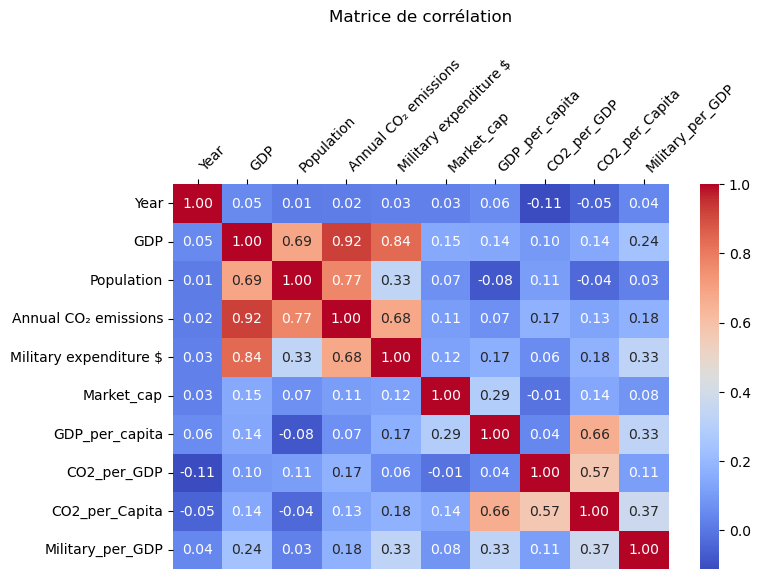

In [9]:
# Filtrer uniquement les colonnes numériques
numeric_df = df_final.select_dtypes(include=['float64', 'int64'])

# Création de la matrice de corrélation
correlation_matrix = numeric_df.corr()

# Visualisation de la matrice de corrélation avec une heatmap
plt.figure(figsize=(8, 5))  # Taille du graphique (largeur, hauteur)
ax = sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")  # Heatmap avec annotations et couleurs
                                                                              #.2f pour afficher 2 chiffres après la virgule
                                                                              # annot=True pour afficher les valeurs dans les cases

# Déplacement des étiquettes de l'axe des x vers le haut
ax.xaxis.tick_top()

# Rotation des étiquettes pour une meilleure lisibilité (optionnel)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left') # Rotation de 45 degrés vers la gauche

# Ajout d'un titre
plt.title("Matrice de corrélation", loc='center', y=1.4)  # Ajustement du titre pour éviter qu'il chevauche les étiquettes

# Affichage du graphique
plt.show()


***Deuxième Analyste : Corrélation CO2 et PIB + Population***

In [10]:
# Création du graphique de corrélation interactif
fig = px.scatter(
    df_final,
    x='GDP',  # PIB en dollars 
    y='Annual CO₂ emissions',  # Émissions annuelles de CO2
    animation_frame='Year',  # Animation par année
    hover_name='Entity',  # Affiche le nom du pays au survol
    log_x=True,  # Échelle logarithmique pour l'axe X
    log_y=True,  # Échelle logarithmique pour l'axe Y
    color='Annual CO₂ emissions',  # Couleur basée sur les émissions de CO2
    size='Population',  # Taille des points basée sur la population
    size_max=50,  # Taille maximale des points
    title="Corrélation entre PIB et émissions de CO2 par pays",  # Titre du graphique
    labels={
        'GDP': 'PIB ($)',  # Renomme les étiquettes des axes
        'Annual CO₂ emissions': 'Émissions annuelles de CO2 (kg)',
        'Entity': 'Pays'
    },
)

# Personnalisation du layout
fig.update_layout(
    margin=dict(l=50, r=20, t=50, b=50), # Ajustement des marges du graphique pour une meilleure lisibilité (gauche, droite, haut, bas)
    xaxis=dict(range=[10, 14]),  # Ajustement de le plage de donnée de l'abscisse pour une meilleure lisibilité (10^10 à 10^14) [Échelle logarithmique]
    yaxis=dict(range=[5, 12]),   # Ajustement de le plage de donnée de l'ordonnée pour une meilleure lisibilité (10^5 à 10^12)[Échelle logarithmique]
) 

# Affichage du graphique interactif
fig.show()


***Troisième Analyse : Classement pays par ratio CO2/habitant***

In [11]:
# Création d'un slider pour sélectionner une année
year_slider = widgets.IntSlider(
    min=df_final['Year'].min(),
    max=df_final['Year'].max(),
    step=1,
    value=df_final['Year'].min(),
    description='Année:',
    continuous_update=True
)

# Fonction pour mettre à jour le graphique en fonction de l'année sélectionnée
def update_plot(year):
    # Filtrer les données pour l'année sélectionnée
    df_year = df_final[df_final['Year'] == year] # On garde uniquement les données pour l'année sélectionnée
    
    # Sélection des 10 pays avec les ratios CO2/Habitant les plus élevés
    top_10_polluters = df_year.groupby('Entity')['CO2_per_Capita'].mean().sort_values(ascending=False).head(10) 
    # On regroupe les données par pays et on calcule la moyenne du ratio CO2/Habitant pour chaque pays puis on garde les 10 premiers
    # Ici .mean est utilisé pour s'assurer qu'il n'y a qu'une seule valeur par pays, même dans le cas ou les données sont propres, mesure de précaution

    # Création du graphique
    plt.figure(figsize=(10, 6))
    sns.barplot(
        y=top_10_polluters.index, # On met les pays en ordonnée
        x=top_10_polluters.values, # On met les valeurs des ratios CO2/Habitant en abscisse
        hue=top_10_polluters.index,  # Ajout de la variable 'hue' pour éviter un avertissement de Seaborn 
        palette="viridis",  # Palette de couleurs
        dodge=False  # Empêche le décalage des barres
    )
    

    # Personnalisation du graphique
    plt.title(f'Top 10 des pays avec le ratio CO2 (en tonnes)/Habitant le plus élevé en {year}', fontsize=16) 
    # le f permet d'insérer une variable dans une chaîne de caractères, ici la variable est l'année
    
    plt.xlabel('Ratio CO2/Habitant (tonnes)', fontsize=12)
    plt.ylabel('Pays', fontsize=12)
    
    # Affichage des valeurs sur les barres
    for i, v in enumerate(top_10_polluters.values): # On parcourt les valeurs du top 10 des pollueurs 
        plt.text(v + 0.1, i, f'{v:.2f}', va='center', fontsize=10) # On affiche la valeur de chaque barre avec 2 chiffres après la virgule et un décalage de 0.1 vers la droite 
    
    # Afficher le graphique
    plt.tight_layout() # Ajustement automatique du graphique pour éviter les chevauchements
    plt.show()

# Création d'un widget interactif pour connecter le slider à la fonction
interactive_plot = interactive(update_plot, year=year_slider)

# Affichage du widget interactif
display(interactive_plot)


interactive(children=(IntSlider(value=2002, description='Année:', max=2022, min=2002), Output()), _dom_classes…

***Dernière analyse : Carte des dépenses Militaires pour chaque pays par PIB***

In [13]:
# Création de la carte interactive
fig = px.choropleth(
    df_final,
    locations="Code",  # Code ISO 3 des pays
    color="Military_per_GDP",  # Ratio dépenses militaires/PIB (%)
    hover_name="Entity",  # Nom du pays au survol
    animation_frame="Year",  # Slider interactif pour les années
    title="Ratio Dépenses Militaires / PIB par Pays (2002-2022)",  # Titre de la carte
    labels={
        "Military_per_GDP": "Dépenses Militaires (% du PIB)",
        "Entity": "Pays",
        "Year": "Année"
    },
    color_continuous_scale="Reds"  # Palette de couleurs rouge dégradée
)

# Personnalisation de la carte
fig.update_layout(
    geo=dict(
        showframe=False,  # Désactive le cadre autour de la carte
        showcoastlines=True,  # Affiche les lignes de côtes
        projection_type="natural earth1"  # Projection naturelle pour une meilleure lisibilité
    ),
    coloraxis_colorbar=dict(
        title="Dépenses Militaires<br>(% du PIB)",  # Titre de la barre de couleur
        tickformat=".2f"  # Format des ticks en décimal
    ),
    width=1280,  # Largeur augmentée pour agrandir la carte 
    height=720   # Hauteur augmentée pour agrandir la carte
)

# Affichage de la carte interactive
fig.show()
